# **IMPORT MODULES/FUNCTIONS**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from efficient_kan.src.efficient_kan import KAN
#from kan import *
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
from functions import get_mean_pulse_from_set, momentos, gauss, gauss_fit, move_to_reference, create_and_delay_pulse_pair, pulso, create_position, set_seed, calculate_gaussian_center_sigma
from functions_KAN import n_params_KAN, train_loop_KAN

In [3]:
V55= np.load('/home/josea/Co60_5cm_5cm.npy')
V28= np.load('/home/josea/Co60_2cm_8cm.npy')
V82= np.load('/home/josea/Co60_8cm_2cm.npy')

#source = 'Co60'
#path = '/home/josea/PracticaTimingDigital/pulso_' + source + '_filt_norm.npz'
#
#data = np.load(path)
#pulsos_practica_master = data['data']


data = np.load('/home/josea/pulsos_Co60_filt_norm_5k_polyfit.npz')
pulsos_practica_master = data['data']

# **INTERPOLATION**

In [4]:
REALS = np.concatenate((V28, V55, V82), axis = 0)
#--------------------------------Interpolar pulsos reales---------------------------------
input = REALS
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_REALS = interp1d(tiempo, REALS, kind = 'cubic', axis = 1)
new_REALS = interp_func_REALS(tiempo_new)

interp_func_practica = interp1d(tiempo,pulsos_practica_master, kind = 'cubic', axis = 1)
new_pulsos_practica = interp_func_practica(tiempo_new)


#--------------------------------------- Align the pulses -----------------------------------
align_steps = 20
new_pulsos_practica[:,:,1] = np.roll(new_pulsos_practica[:,:,1], align_steps)
new_pulsos_practica[:,:align_steps,1] = np.random.normal(scale = 1e-3, size = align_steps)

print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 600
Time step: 0.20
New number of time points: 4800
New time step: 0.0250


# **GENERATE MEAN PULSE PER DETECTOR**

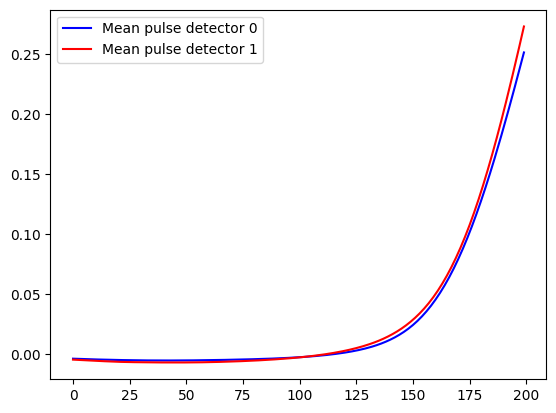

In [5]:
mean_pulse_dec0 = get_mean_pulse_from_set(new_pulsos_practica, channel = 0)
mean_pulse_dec1 = get_mean_pulse_from_set(new_pulsos_practica, channel = 1)

#-------------------------------------- Plot cropped mean pulses -----------------------------
start = 50*EXTRASAMPLING #50
stop = 75*EXTRASAMPLING

plt.plot(mean_pulse_dec0[start:stop], 'b-', label = 'Mean pulse detector 0')
plt.plot(mean_pulse_dec1[start:stop], 'r-', label = 'Mean pulse detector 1')
plt.legend()

# **DETECTORS**

In [6]:
#------------------------------------ Important definitions ------------------------------------
ajuste_grueso = 1 # 0 = YES, 1 = NO
delay_steps = 30  # Max number of steps to delay pulses
moments_order = 4  # Max order of moments used
Num_casos = 0 # Number of simulated pulses
set_seed(42) #Fix seeds
nbins = 51 #Num bins for all histograms



t_shift = 8 #In time steps
t = np.linspace(0, Nt, Nt_new)
t0 = 65 + np.random.randint(10, size = Num_casos)  


# Define size of train set from datos practica
Ntrain_practica = int(0.8*new_pulsos_practica.shape[0])
Ntest_practica = int(0.2*new_pulsos_practica.shape[0])
print('Número de casos de entrenamiento de la práctica: ', Ntrain_practica)
print('Número de casos de Test de la práctica: ', Ntest_practica)

Número de casos de entrenamiento de la práctica:  3836
Número de casos de Test de la práctica:  959


In [7]:
#--------------------------------- Detector 0 definitions -------------------------
tau_rise_dec0 = 20
tau_drop_dec0 = 150
Photon_yield = 100
center_window_dec0 = 0.0
rise_window_dec0 = 0.0

#--------------------------------- Detector 1 definitions -------------------------
tau_rise_dec1 = 20
tau_drop_dec1 = 150
Photon_yield = 100
center_window_dec1 = 0.0
rise_window_dec1 = 0.0

In [8]:
#------------------------------ Create simulated pulses ---------------------------------
INPUT_dec0 = np.zeros((Num_casos, Nt_new))
INPUT_dec1 = np.zeros((Num_casos, Nt_new))

for i in range(Num_casos):
  PULSO_dec0 = pulso(t, t0[i], tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0)
  PULSO_dec1 = pulso(t, t0[i], tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1)
  INPUT_dec0[i,:] = PULSO_dec0
  INPUT_dec1[i,:] = PULSO_dec1

Text(0.5, 1.0, 'Detector 1')

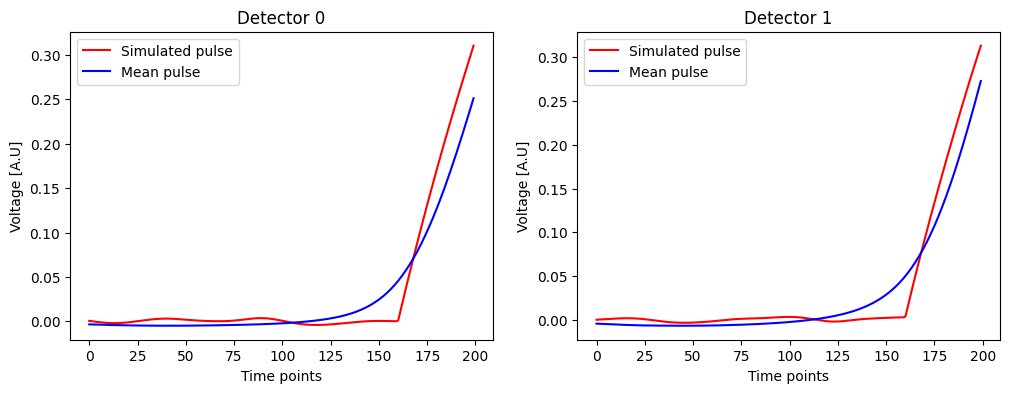

In [9]:
pulso_original_dec0 = pulso(t, 70, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0)
pulso_original_dec1 = pulso(t, 70, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1)


plt.figure(figsize = (12,4))
plt.subplot(121)
plt.plot(pulso_original_dec0[start:stop],'r-', label = 'Simulated pulse')
plt.plot(mean_pulse_dec0[start:stop],'b-', label = 'Mean pulse')
plt.legend()
plt.xlabel('Time points')
plt.ylabel('Voltage [A.U]')
plt.title('Detector 0')

plt.subplot(122)
plt.plot(pulso_original_dec1[start:stop],'r-', label = 'Simulated pulse')
plt.plot(mean_pulse_dec1[start:stop],'b-', label = 'Mean pulse')
plt.legend()
plt.xlabel('Time points')
plt.ylabel('Voltage [A.U]')
plt.title('Detector 1')

In [10]:
if ajuste_grueso == 0:

    # Move simulated pulses  to align with mean and delay
    if Num_casos != 0:
        delays_dec0, moved_pulses_dec0 = move_to_reference(mean_pulse_dec0, np.expand_dims(INPUT_dec0, axis = -1), start = start, stop = stop, max_delay = int(stop-start), channel = 0)
        delays_dec1, moved_pulses_dec1 = move_to_reference(mean_pulse_dec1, np.expand_dims(INPUT_dec1, axis = -1), start = start, stop = stop, max_delay = int(stop-start), channel = 0)
    
        INPUT_dec0, REF_dec0 = create_and_delay_pulse_pair(moved_pulses_dec0, new_time_step, delay_steps = delay_steps, NOISE = True)
        INPUT_dec1, REF_dec1 = create_and_delay_pulse_pair(moved_pulses_dec1, new_time_step, delay_steps = delay_steps, NOISE = True)
    
    if Num_casos == 0:
        INPUT_dec0 = np.zeros((Num_casos, int(stop-start), 2))
        INPUT_dec1 = np.zeros((Num_casos, int(stop-start), 2))
        REF_dec0 = np.zeros((Num_casos,))
        REF_dec1 = np.zeros((Num_casos,))
    
    # Move rest of the pulses to align with mean and then delay them 
    delays2_dec0, moved_pulses2_dec0 = move_to_reference(mean_pulse_dec0, new_pulsos_practica[:Ntrain_practica,:,:], start = start, stop = stop, max_delay = int(stop-start), channel = 0)
    delays2_dec1, moved_pulses2_dec1 = move_to_reference(mean_pulse_dec1, new_pulsos_practica[:Ntrain_practica,:,:], start = start, stop = stop, max_delay = int(stop-start), channel = 1)
    
    INPUT2_dec0, REF2_dec0 = create_and_delay_pulse_pair(moved_pulses2_dec0, new_time_step, delay_steps = delay_steps, NOISE = True)
    INPUT2_dec1, REF2_dec1 = create_and_delay_pulse_pair(moved_pulses2_dec1, new_time_step, delay_steps = delay_steps, NOISE = True)


if ajuste_grueso == 1:

    INPUT_dec0, REF_dec0 = create_and_delay_pulse_pair(INPUT_dec0[:,start:stop], new_time_step, delay_steps = delay_steps, NOISE = True)
    INPUT_dec1, REF_dec1 = create_and_delay_pulse_pair(INPUT_dec1[:,start:stop], new_time_step, delay_steps = delay_steps, NOISE = True)

    INPUT2_dec0, REF2_dec0 = create_and_delay_pulse_pair(new_pulsos_practica[:Ntrain_practica,start:stop,0], new_time_step, delay_steps = delay_steps, NOISE = True)
    INPUT2_dec1, REF2_dec1 = create_and_delay_pulse_pair(new_pulsos_practica[:Ntrain_practica,start:stop,1], new_time_step, delay_steps = delay_steps, NOISE = True)
    
    
# Create train set 
trainX_dec0 = np.concatenate((INPUT_dec0, INPUT2_dec0), axis = 0)
trainX_dec1 = np.concatenate((INPUT_dec1, INPUT2_dec1), axis = 0)

REF_train_dec0 = np.concatenate((REF_dec0, REF2_dec0))
REF_train_dec1 = np.concatenate((REF_dec1, REF2_dec1))

Text(0.5, 1.0, 'Detector 1')

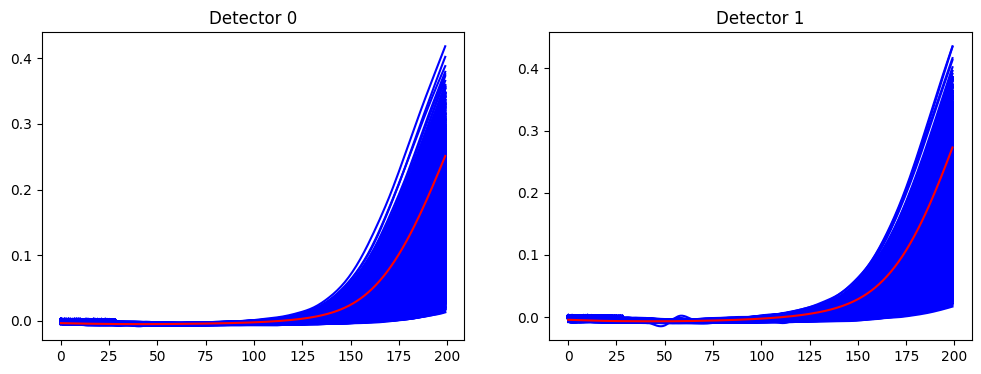

In [11]:
plt.figure(figsize = (12,4))

plt.subplot(121)
for i in range(trainX_dec0.shape[0]):
    plt.plot(trainX_dec0[i,:,0],'b-')
plt.plot(mean_pulse_dec0[start:stop],'r-')
plt.title('Detector 0')

plt.subplot(122)
for i in range(trainX_dec1.shape[0]):
    plt.plot(trainX_dec1[i,:,0],'b-')
plt.plot(mean_pulse_dec1[start:stop],'r-')
plt.title('Detector 1')

In [12]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec0 = momentos(trainX_dec0, order = moments_order)
M_Train_dec1 = momentos(trainX_dec1, order = moments_order)

#-------------------------------------------------------------- Normalize ---------------------------------------------------
min_dec0 = np.min(M_Train_dec0)
max_dec0 = np.max(M_Train_dec0)

min_dec1 = np.min(M_Train_dec1)
max_dec1 = np.max(M_Train_dec1)

M_Train_dec0 = (M_Train_dec0 - min_dec0)/(max_dec0 - min_dec0)
M_Train_dec1 = (M_Train_dec1 - min_dec1)/(max_dec1 - min_dec1)  


#-------------------------------------------------------------- Print information ---------------------------------------------------
NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape, "NM =", NM)
print("Min detector 0:", min_dec0)
print("Max detector 0:", max_dec0)

NM = np.shape(M_Train_dec1)[1]
print(M_Train_dec1.shape, "NM =", NM)
print("Min detector 1:", min_dec1)
print("Max detector 1:", max_dec1)

(3836, 4, 2) NM = 4
Min detector 0: -0.3825994548789333
Max detector 0: 12.169152982082245
(3836, 4, 2) NM = 4
Min detector 1: -0.5956897777824304
Max detector 1: 11.566595204226832


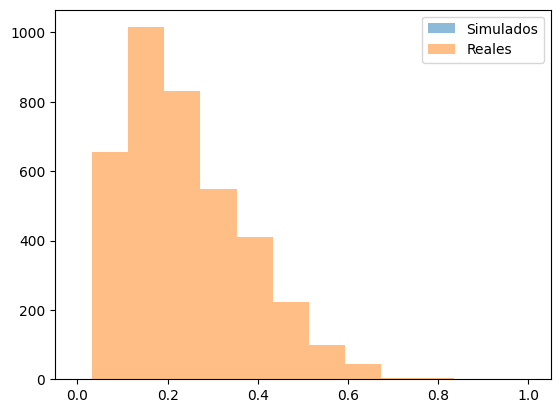

In [13]:
plt.hist(M_Train_dec0[:Num_casos,2,0], alpha = 0.5, label = 'Simulados');
plt.hist(M_Train_dec0[Num_casos:,2,0], alpha = 0.5, label = 'Reales');
plt.legend()

# **FULL TOF (KAN)**

In [14]:
#-------------------------------- Create test set ---------------------------------------------------------
if ajuste_grueso == 0:
    delays_test_dec0, moved_pulses_test_dec0 = move_to_reference(mean_pulse_dec0, new_REALS, start = start, stop = stop, max_delay = int(stop-start), channel = 0)
    delays_test_dec1, moved_pulses_test_dec1 = move_to_reference(mean_pulse_dec1, new_REALS, start = start, stop = stop, max_delay = int(stop-start), channel = 1)
    TEST = np.stack((moved_pulses_test_dec0, moved_pulses_test_dec1), axis = 2)

if ajuste_grueso == 1:
    #TEST_00 = new_REALS[V28.shape[0] : V28.shape[0] + V55.shape[0], start:stop,:]
    TEST = new_REALS[:,start:stop,:]
    #TEST_00 = new_pulsos_practica[Ntrain_practica:,start:stop,:] 
    #TEST_02 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift, NOISE = True)
    #TEST_20 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift, NOISE = True)
    #TEST = np.concatenate((TEST_02, TEST_00, TEST_20), axis = 0)



MOMENTS_TEST = momentos(TEST, order = moments_order)
MOMENTS_TEST[:,:,0] = (MOMENTS_TEST[:,:,0] - min_dec0)/(max_dec0 - min_dec0)
MOMENTS_TEST[:,:,1] = (MOMENTS_TEST[:,:,1] - min_dec1)/(max_dec1 - min_dec1)

In [15]:
# Define model parameters
architecture = [NM, 3, 1, 1]  
grid_size = 10
k_order = 3

# Initialize model
#model_dec0 = KAN(width = architecture, grid = grid_size, k = k_order, seed = 0)
#model_dec1 = KAN(width = architecture, grid = grid_size, k = k_order, seed = 0)

model_dec0 = KAN(architecture)
model_dec1 = KAN(architecture)
n_params = n_params_KAN(architecture, grid_size, k_order)
print('Number of parameters for this architecture:', n_params) #Se calcula el número de parametros igual en efficient kan?

Number of parameters for this architecture: 208


In [16]:
# Create Dataset
train_dataset_dec0 = torch.utils.data.TensorDataset(torch.from_numpy(M_Train_dec0).float(), torch.from_numpy(np.expand_dims(REF_train_dec0, axis = -1)).float())
train_dataset_dec1 = torch.utils.data.TensorDataset(torch.from_numpy(M_Train_dec1).float(), torch.from_numpy(np.expand_dims(REF_train_dec1, axis = -1)).float())

# Create DataLoaders
train_loader_dec0 = torch.utils.data.DataLoader(train_dataset_dec0, batch_size = 32, shuffle = True)
train_loader_dec1 = torch.utils.data.DataLoader(train_dataset_dec1, batch_size = 32, shuffle = True)

optimizer_dec0 = torch.optim.AdamW(model_dec0.parameters(), lr = 2e-4) #Regularization?
optimizer_dec1 = torch.optim.AdamW(model_dec1.parameters(), lr = 2e-4) #5e-5

In [17]:
# Execute train loop
loss_dec0, test_dec0 = train_loop_KAN(model_dec0, optimizer_dec0, train_loader_dec0, torch.tensor(MOMENTS_TEST[:,:,0]).float(), EPOCHS = 300, save = False) 
loss_dec1, test_dec1 = train_loop_KAN(model_dec1, optimizer_dec1, train_loader_dec1, torch.tensor(MOMENTS_TEST[:,:,1]).float(), EPOCHS = 300, save = False)

EPOCH 1:
LOSS train 0.09312356438706904
EPOCH 2:
LOSS train 0.09148511716297694
EPOCH 3:
LOSS train 0.08862859774537447
EPOCH 4:
LOSS train 0.08291335516617078
EPOCH 5:
LOSS train 0.07367915707100339
EPOCH 6:
LOSS train 0.06180843654550424
EPOCH 7:
LOSS train 0.049414678155875004
EPOCH 8:
LOSS train 0.03939045120437606
EPOCH 9:
LOSS train 0.03232716133489328
EPOCH 10:
LOSS train 0.02736688033528939
EPOCH 11:
LOSS train 0.023697736900018043
EPOCH 12:
LOSS train 0.020844347195840683
EPOCH 13:
LOSS train 0.018480593029472258
EPOCH 14:
LOSS train 0.01630033671996799
EPOCH 15:
LOSS train 0.014403001254643588
EPOCH 16:
LOSS train 0.01266603241087634
EPOCH 17:
LOSS train 0.011064835019926188
EPOCH 18:
LOSS train 0.009659712251761005
EPOCH 19:
LOSS train 0.008433615678760904
EPOCH 20:
LOSS train 0.007358588400578611
EPOCH 21:
LOSS train 0.0064579862480036165
EPOCH 22:
LOSS train 0.005665236553314197
EPOCH 23:
LOSS train 0.00503695196767549
EPOCH 24:
LOSS train 0.0045033416802752295
EPOCH 25:
L

/home/josea/DEEP_TIMING/DEEP_TIMING_VS/functions.py:40: RuntimeWarning: divide by zero encountered in divide
  return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
/home/josea/DEEP_TIMING/DEEP_TIMING_VS/functions.py:40: RuntimeWarning: invalid value encountered in divide
  return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
/home/josea/DEEP_TIMING/DEEP_TIMING_VS/functions.py:44: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
/home/josea/DEEP_TIMING/DEEP_TIMING_VS/functions.py:42: RuntimeWarning: invalid value encountered in scalar divide
  mean = sum(x * y) / sum(y)


279 0.05438327852261637


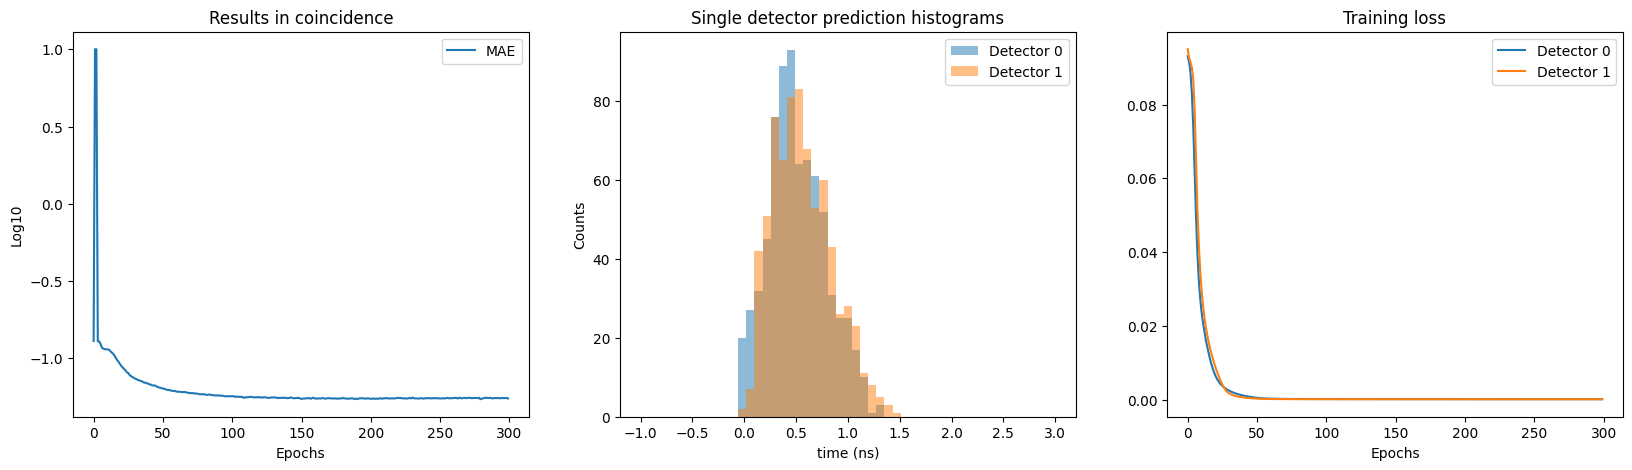

In [18]:
if ajuste_grueso == 0:
    TOFN = (test_dec0 - new_time_step*delays_test_dec0) - (test_dec1 - new_time_step*delays_test_dec1)
    TOFN_V28 = TOFN[:,:V28.shape[0]] - test_dec1[:,: V28.shape[0]]
    TOFN_V55 = TOFN[:,V28.shape[0] : V28.shape[0] + V55.shape[0]]  - test_dec1[:,V28.shape[0] :V28.shape[0] + V55.shape[0]] 
    TOFN_V82 = TOFN[:,V28.shape[0] + V55.shape[0]:] - test_dec1[:,V28.shape[0] + V55.shape[0]:] 

if ajuste_grueso == 1:
    TOFN_V28 = test_dec0[:,:V28.shape[0]] - test_dec1[:,:V28.shape[0]]
    TOFN_V55 = test_dec0[:,V28.shape[0] :V28.shape[0] + V55.shape[0]] - test_dec1[:,V28.shape[0] :V28.shape[0] + V55.shape[0]]
    TOFN_V82 = test_dec0[:,V28.shape[0] + V55.shape[0]:] - test_dec1[:,V28.shape[0] + V55.shape[0]:]

    #TOFN_V28 = test_dec0[:,:TEST_00.shape[0]] - test_dec1[:,:TEST_00.shape[0]]
    #TOFN_V55 = test_dec0[:,TEST_00.shape[0] : 2*TEST_00.shape[0]] - test_dec1[:, TEST_00.shape[0] : 2*TEST_00.shape[0]]
    #TOFN_V82 = test_dec0[:,2*TEST_00.shape[0]:] - test_dec1[:,2*TEST_00.shape[0]:]
    

# Must turn to float64 in order to calculate std on a specific axis
TOFN_V28 = np.array(TOFN_V28, dtype = 'float64') 
TOFN_V55 = np.array(TOFN_V55, dtype = 'float64')
TOFN_V82 = np.array(TOFN_V82, dtype = 'float64') 

# Calculate 'centroids'
centroid_V55, sigmaN_V55 = calculate_gaussian_center_sigma(TOFN_V55, np.zeros((TOFN_V55.shape[0])), nbins = nbins)  
centroid_V28, sigmaN_V28 = calculate_gaussian_center_sigma(TOFN_V28, centroid_V55, nbins = nbins)
centroid_V82, sigmaN_V82 = calculate_gaussian_center_sigma(TOFN_V82, centroid_V55, nbins = nbins)

# Get errors to calculate Epsilon
error_V28 = abs((TOFN_V28 - centroid_V55[:, np.newaxis] + 0.2))
error_V55 = abs((TOFN_V55 - centroid_V55[:, np.newaxis]))
error_V82 = abs((TOFN_V82 - centroid_V55[:, np.newaxis] - 0.2))

Error = np.concatenate((error_V28, error_V55, error_V82), axis = 1)
MAE = np.mean(Error, axis = 1)
idx_min_MAE = np.where(MAE == np.min(MAE))[0][0]
print(idx_min_MAE, np.min(MAE))


# PLot
plt.figure(figsize = (20,5))
plt.subplot(131)
plt.plot(np.log10(MAE[:]), label = 'MAE')
plt.title('Results in coincidence')
plt.xlabel('Epochs')
plt.ylabel('Log10')
plt.legend()

plt.subplot(132)
if ajuste_grueso == 0:
    plt.hist(test_dec0[idx_min_MAE , :] - new_time_step*delays_test_dec0, bins = nbins, range = [-1, 3], alpha = 0.5, label = 'Detector 0');
    plt.hist(test_dec1[idx_min_MAE , :] - new_time_step*delays_test_dec1, bins = nbins, range = [-1, 3], alpha = 0.5, label = 'Detector 1');

if ajuste_grueso == 1:
    plt.hist(test_dec0[idx_min_MAE , :], bins = nbins, range = [-1, 3], alpha = 0.5, label = 'Detector 0');
    plt.hist(test_dec1[idx_min_MAE , :], bins = nbins, range = [-1, 3], alpha = 0.5, label = 'Detector 1');

plt.title('Single detector prediction histograms')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.legend()

plt.subplot(133)
plt.plot(loss_dec0[:], label = 'Detector 0')
plt.plot(loss_dec1[:], label = 'Detector 1')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.legend()


V82: CENTROID(ns) = 0.198  FWHM(ns) = 0.164  std(ns) = 0.069
V55: CENTROID(ns) = 0.004  FWHM(ns) = 0.155  std(ns) = 0.066
V28: CENTROID(ns) = -0.211  FWHM(ns) = 0.165  std(ns) = 0.070


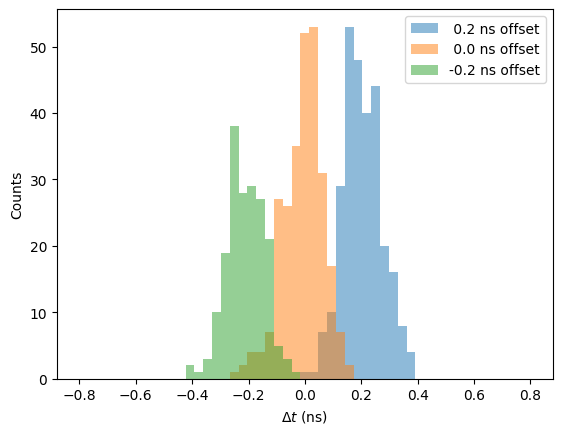

In [19]:
epoch = idx_min_MAE
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
histogN_V82, binsN, patchesN  = plt.hist(TOFN_V82[epoch,:] - centroid_V55[epoch], bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = ' 0.2 ns offset');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(TOFN_V55[epoch,:] - centroid_V55[epoch], bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = ' 0.0 ns offset');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(TOFN_V28[epoch,:] - centroid_V55[epoch], bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = '-0.2 ns offset');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()
plt.xlabel('$\Delta t$ (ns)')
plt.ylabel('Counts')

FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))

In [20]:
import time

time_test = np.tile(trainX_dec0[0,:,:], (1000000, 1,1))

# Start timer moments
start_time_momentos = time.time()
M_time_test = momentos(time_test, order = moments_order)
end_time_momentos = time.time()


# Start timer inference
start_time_inference= time.time()
with torch.no_grad():
    assert not torch.is_grad_enabled()
    output_time_test = model_dec0(torch.tensor(M_time_test[:,:,0]).float())
end_time_inference = time.time()

# Calculate the elapsed times
elapsed_time_momentos = end_time_momentos - start_time_momentos
elapsed_time_inference = end_time_inference - start_time_inference

print(f"Elapsed time momentos: {elapsed_time_momentos} seconds")
print(f"Elapsed time inference: {elapsed_time_inference} seconds")

Elapsed time momentos: 11.346758842468262 seconds
Elapsed time inference: 0.5487310886383057 seconds


Text(0, 0.5, 'Absolute error')

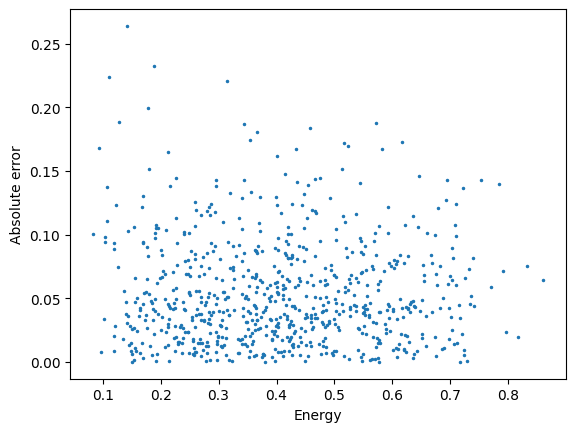

In [21]:
energy = MOMENTS_TEST[:,2,:]

plt.plot(energy[:,1], Error[epoch,:], 'o', markersize = 1.5)
plt.xlabel('Energy')
plt.ylabel('Absolute error')